In [328]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import time

warnings.filterwarnings('ignore')

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from termcolor import colored
import tensorflow.keras.backend as K

In [329]:
print(time.time())

1588068617.28622


## Load and prepare data

### Raw data

The training data consists of the following sets: 
- 200 keV, 100 ms
- 200 keV, 10 ms
- 60 keV, 100 ms
- 60 keV, 10 ms

1) Import all data points from text files using Pandas

2) Apply a window: the raw spectra are calibrated with their peak around 0 eV loss, but the length of each spectrum differs. Therefore, a window is applied to the input data: it selects the data of all input spectra between [-0.2, 0.5] eV loss 

3) Use 'sklearn.train_test_split' to split the data into training and validation points




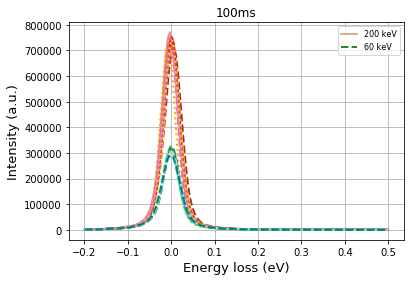

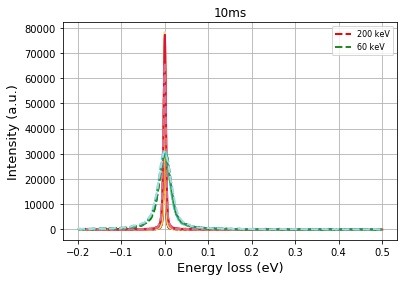

In [350]:
mode = 'Mixture'
%run EELS-ZLP-Mar.py

## Data preprocessing

Unscaled input variables can result in a slow or unstable learning process, whereas unscaled target variables on regression problems can result in exploding gradients causing the learning process to fail. [1]

The energy loss is scaled between [-1, 1] and all input spectra are scaled between [0.1, 0.9]. 

### Binning
The discretization technique used to assign mean and standard deviation the data points is called Equal Width Discretization [2]. EWD is a simple discretization method that divides the range of observed values for a feature into k equal sized bins. The intervals are computed by 
 $\Delta E = (E_{max} - E_{min}) / k$. \
 Then, within each energy bin $\Delta E$, the mean and variance of all data points within this bin are determined and returned to the original data points. This way, each data point is a vector $[dE, D_i, \sigma_i]$ where dE is the original energy loss; $D_i$ and $\sigma_i$ are the mean and std of the bin $i$ where this point belongs to.  Note that the number of data points within each bin is not necessarily the same. The minimum and maximum number of data points within each bin can be found in the output.

[1] https://github.com/juanrojochacon/ml-ditp-attp/blob/master/Tutorials/Tutorial2/notebooks/Tutorial2a-NonLinearRegression-GLUON.ipynb

[2] (PDF) Comparative Analysis of Supervised and Unsupervised Discretization Techniques. Available from: https://www.researchgate.net/publication/266058863_Comparative_Analysis_of_Supervised_and_Unsupervised_Discretization_Techniques [accessed Apr 16 2020].


Stored 'energy' (int)
Stored 'time' (int)
Stored 'nbins' (int)
With 500 bins, the minimum number of training points within each bin is 8 and maximum is 33


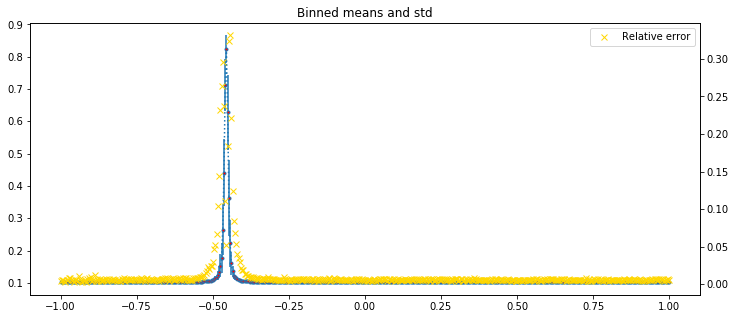

In [331]:
%run Functions.ipynb
fig = plt.gcf()
from copy import copy

time = 10
energy = 200
nbins = 500
minval = -1
maxval = +1

%store energy
%store time
%store nbins

x_train, y_train = prepare_mix_data(time, energy)
x_train = np.interp(x_train, (x_train.min(), x_train.max()), (-1, 1))
y_train = np.interp(y_train, (y_train.min(), y_train.max()), (0.1, 0.9))


# Store output vectors for training
df_train, cuts1_t, cuts2_t = ewd(x_train, y_train)
mean_t, std_t, count_t= binned_statistics(x_train, y_train)
variance_vector_t = vectorize_variance(x_train, y_train)
mean_vector_t = vectorize_mean(x_train, y_train)
# create one vector with (x_train, y_train, sigma_train)
df_train = np.c_[df_train[:,0], mean_vector_t, variance_vector_t]

print("With", nbins, "bins, the minimum number of training points within each bin is", int(min(count_t)), "and maximum is", int(max(count_t)))

# Create a plot of the mean & std 
plot_uncertainties(x_train, y_train, nbins, minval, maxval)
ax2 = plt.twinx()
ax2.plot(np.linspace(minval, maxval, nbins), np.divide(std_t, mean_t), 'x', color='gold',  label='Relative error')
#ax2.plot_uncertainties(x_train, y_train, nbins, minval, maxval)
plt.legend()
fig.set_size_inches(12, 5)
plt.show()


In [332]:
#np.savetxt('Data/10ms200keV_nbins=500.csv', df_train, delimiter=",")

## Closure testing

In order to test if the computed error associated to each training point is reasonable, a method called Closure Testing can provide insight.  The 'true' values are then the best Gaussian fit sampled at the energy data of the training points. The parameters of the best fit are determined in the notebook *Gaussian.ipynb* and are fitted to the original data points (before binning).

In [333]:
#%run Gaussian.ipynb

#y_gaus = gaussian(df_train[:,0], amp10, cen10, std10 )

#plt.plot(df_train[:,0], y_gaus, 'o')

### Merge all data for training

In [334]:
f1 = pd.read_csv('Data/100ms60keV_nbins=180.csv', header=None)
f1['time'] = 1
f1['energy'] = .6
f2 = pd.read_csv('Data/100ms200keV_nbins=180.csv', header=None)
f2['time'] = 1
f2['energy'] = 2
f3 = pd.read_csv('Data/10ms200keV_nbins=500.csv', header=None)
f3['time'] = .1
f3['energy'] = 2
f4 = pd.read_csv('Data/10ms60keV_nbins=180.csv', header=None)
f4['time'] = .1
f4['energy'] = .6
frames = f1.append(f4).append(f2).append(f3).append(f4)
frames.to_csv('Data/training_merged_3.csv', index=None, header=['x', 'y', 'sigma', 'time', 'energy'])


## Neural Network 

### Create architecture

In [335]:
def make_model(inputs, n_outputs):

    hidden_layer_1 = tf.layers.dense(inputs, 10, activation=tf.nn.leaky_relu)
    hidden_layer_2 = tf.layers.dense(hidden_layer_1, 15, activation=tf.nn.sigmoid)
    hidden_layer_3 = tf.layers.dense(hidden_layer_2, 10, activation=tf.nn.sigmoid)
    #hidden_layer_4 = tf.layers.dense(hidden_layer_3, 5, activation=tf.nn.sigmoid)
    #hidden_layer_3 = tf.layers.dropout(hidden_layer_3, 0.01)
    output = tf.layers.dense(hidden_layer_3, n_outputs, name='outputs', reuse=tf.AUTO_REUSE)

    return output



### Prepare data for training

Cost function: $\chi^2 = 1/N \sum (y - y_{pred})^2 / \sigma^2$ \
Optimizer: AdamOptimizer, $\eta = 0.02$\

Training points are generated by Monte Carlo sampling; for the set of training points $[dE, D_i, \sigma_i]$, a set of MC training points is generated by adding a stochastic noise signal on top of the the data with a std equal to the corresponding error on that point. 

- **train_x**: $[dE, t_{exp}]$
- **train_y**: $D_i$ + rand.norm(0, $\sigma_i$)

Repetitive training of the NN (number of repetitions = $N_{rep}$) on each set of MC pseudo data yields a prediction that is distributed with a mean and std corresponding to the mean and error of the original training set. 


In [345]:
tf.reset_default_graph()
from copy import copy
from sklearn.model_selection import train_test_split

x = tf.placeholder("float", [None, 3])
y = tf.placeholder("float", [None, 1])
sigma = tf.placeholder("float", [None, 1])

df_train_full = pd.read_csv('Data/training_merged_3.csv', header=0)
df_train, df_test = train_test_split(df_train_full, test_size=0.15)

train_x = np.array(df_train[['x', 'time', 'energy']].to_numpy())
N_train = len(train_x[:,0])
train_y = np.copy(df_train['y']).reshape(N_train,1)
train_sigma = np.copy(df_train['sigma']).reshape(N_train,1)

test_x = np.array(df_test[['x', 'time', 'energy']].to_numpy())
N_test = len(test_x[:,0])
test_y = np.copy(df_test['y']).reshape(N_test,1)
test_sigma = np.copy(df_test['sigma']).reshape(N_test,1)


predictions = make_model(x,1)




## Set a restriction for the minimum relative error

In [354]:
relative_error = np.divide(train_sigma, train_y)
treshold = 0.001
treshold_error_index = np.where(relative_error > treshold)[0]
train_x, train_y, train_sigma = train_x[treshold_error_index], train_y[treshold_error_index], train_sigma[treshold_error_index]
N_train = len(train_x)

relative_error = np.divide(test_sigma, test_y)
treshold_error_index = np.where(relative_error > treshold)[0]
test_x, test_y, test_sigma = test_x[treshold_error_index], test_y[treshold_error_index], test_sigma[treshold_error_index]
N_test = len(test_x)

## Create MC replicas

In [347]:
### Create array of Nrep training samples
Nrep = 1000
#pbar = tqdm(total=Nrep)
train_y_reps = np.zeros(shape=(N_train, Nrep))
test_y_reps = np.zeros(shape=(N_test, Nrep))
i=0
while i < Nrep:
    train_rep = np.random.normal(0, train_sigma)
    test_rep = np.random.normal(0, test_sigma)
    train_y_reps[:,i] = (train_y + train_rep).reshape(N_train)
    test_y_reps[:,i] = (test_y + test_rep).reshape(N_test)
    
    i+=1 
train_y_reps[train_y_reps < .1] = .1    
test_y_reps[test_y_reps < .1] = .1
std_reps = np.std(train_y_reps, axis=1)
mean_reps = np.mean(train_y_reps, axis=1)

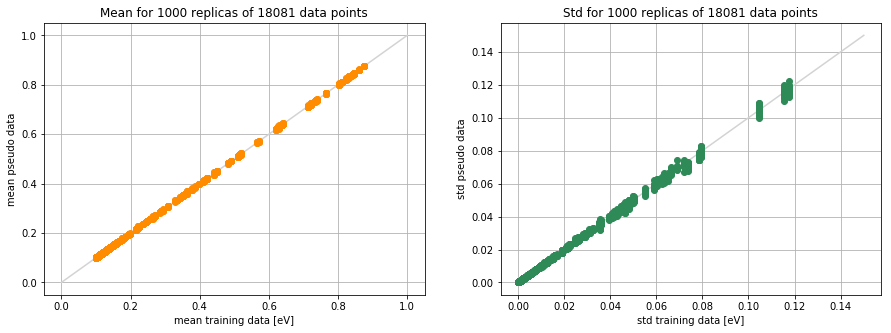

In [348]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(train_y, mean_reps, 'o', color = 'darkorange', label = 'Predictions pseudodata')
plt.grid(True)
plt.xlabel(r'mean training data [eV]')
plt.ylabel(r'mean pseudo data')

plt.subplot(122)
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(0,0.15,10), np.linspace(0,0.15,10), color='lightgrey')
plt.plot(train_sigma, std_reps, 'o', color='seagreen', label = 'Predictions pseudodata')
plt.xlabel(r'std training data [eV]')
plt.ylabel(r'std pseudo data')

plt.show()

In [349]:
chi_array = []
import time

training_epochs = 40000
max_rising_epochs = 10000 #The amount of epochs the minimzer is allowed to overfit before it stops
display_step = 1000
%store Nrep
%store training_epochs

### Define cost and optimizer
cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="cost_function")
custom_cost = tf.reduce_mean(tf.square((y-predictions)/sigma), name="custom_cost_function")
eta = 3e-2
tic = time.time()

#optimizer = tf.train.GradientDescentOptimizer(learning_rate=eta).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=eta, beta1=0.9, beta2=0.999, epsilon=1e-07).minimize(cost)

i = 0
Nrep = 1

while i < (Nrep):
    
    """Training data: train_y = D_i + rand.norm(0, sigma_i);
    use train_y = gaus_y + rand.norm(0, sigma_i) in case of Closure testing"""
    
    train_y = train_y_reps[:,i].reshape(N_train,1)
    test_y = test_y_reps[:,i].reshape(N_test,1)

    ### Train and validate
    prev_test_cost = 100
    prev_epoch=0
    avg_cost = 0.0
    

    array_train = []
    array_test = []
    
    print("Start training on", '%04d' %(N_train), "and validating on", '%0.4d' %(N_test), "samples")

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        

        for epoch in range(training_epochs):

            _, c = sess.run([optimizer, cost], 
                            feed_dict={
                                x: train_x,
                                y: train_y,
                                sigma: train_sigma
                            })
            avg_cost = c 

            test_cost = cost.eval({x: test_x, y: test_y, sigma: test_sigma})


            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), "| Training cost=", "{:.9f}".format(avg_cost), "| Validation cost=", "{:.9f}".format(test_cost))
                array_train.append(avg_cost)
                array_test.append(test_cost)

            if test_cost >= prev_test_cost and epoch-prev_epoch >= max_rising_epochs:
                print(colored("\n The session stopped because of overfitting...","red"))
                print("Start overfitting at epoch:", '%04d' % (epoch), "| Validation cost =", "{:.9f}".format(test_cost), "| Train cost=", "{:.9f}".format(avg_cost))
                break

            elif test_cost < prev_test_cost:
                prev_test_cost = test_cost
                prev_epoch = epoch


        print("Optimization Finished!")
        predictions_values = sess.run(predictions, 
                            feed_dict={
                                x: train_x,
                                y: train_y 
                            })
        
        
    
    sess.close()

    # save to csv file
    from datetime import datetime
    predictions_values = predictions_values.reshape(N_train,)
    toc = time.time()
    print("Elapsed time:", toc-tic)

    #foot = np.array(seednumber)
    a = np.array(train_x[:,0])
    b = np.array(train_y)
    c = np.array(predictions_values)
    d = array_train
    e = array_test
    
    chi_array.append(d[-1])

    now = datetime.now()
  
    dt_string = now.strftime("%d.%m.%Y %H:%M:%S")
    d_string = now.strftime("%d.%m.%Y")
    t_string = now.strftime("%H:%M:%S")
    
    #np.savetxt('Data/Results/%(date)s/xyp_%(energy)s_%(time)sms_e%(epoch)s_%(i)x.csv' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": i }, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
    #np.savetxt('Data/Results/%(date)s/chi_%(energy)s_%(time)sms_e%(epoch)s_%(i)x.csv' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')
    
    print(i)
    i+=1

Stored 'Nrep' (int)
Stored 'training_epochs' (int)
Start training on 18081 and validating on 3190 samples
Epoch: 0001 | Training cost= 5529976.500000000 | Validation cost= 2265312.750000000
Epoch: 1001 | Training cost= 22.470281601 | Validation cost= 23.035285950
Epoch: 2001 | Training cost= 19.267005920 | Validation cost= 19.677627563
Epoch: 3001 | Training cost= 18.434968948 | Validation cost= 18.684820175
Epoch: 4001 | Training cost= 17.834667206 | Validation cost= 18.119607925
Epoch: 5001 | Training cost= 17.281562805 | Validation cost= 17.597023010
Epoch: 6001 | Training cost= 25.059404373 | Validation cost= 39.237499237
Epoch: 7001 | Training cost= 16.980054855 | Validation cost= 17.378494263
Epoch: 8001 | Training cost= 15.831530571 | Validation cost= 16.233373642
Epoch: 9001 | Training cost= 14.834083557 | Validation cost= 15.343537331
Epoch: 10001 | Training cost= 13.639257431 | Validation cost= 14.268831253
Epoch: 11001 | Training cost= 12.305500984 | Validation cost= 12.9905

### Plot outputs

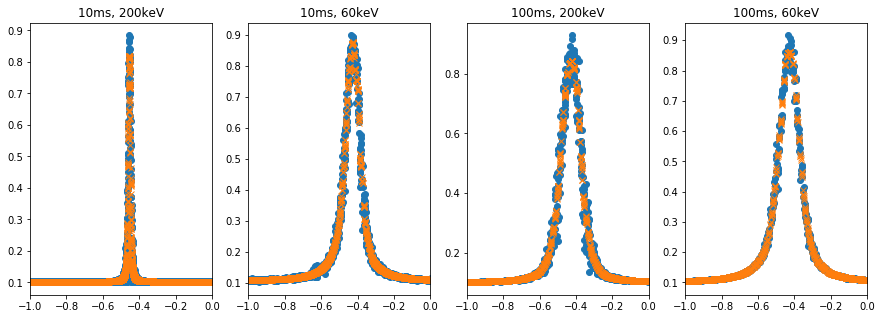

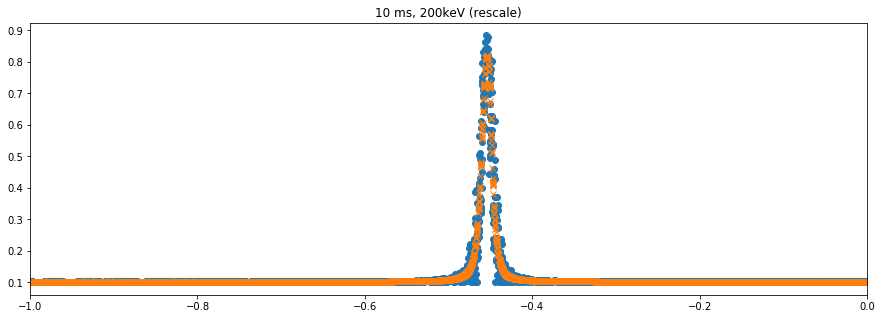

In [353]:
np.savetxt('Data/Results/%(date)s/xyp_%(energy)s_%(time)sms_e%(epoch)s_%(i)x.csv' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": i }, list(zip(a,b,c)),  delimiter=',',  header="Training inputs, Training outputs, Predictions", fmt='%f')
np.savetxt('Data/Results/%(date)s/chi_%(energy)s_%(time)sms_e%(epoch)s_%(i)x.csv' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": i }, list(zip(d,e)),  delimiter=',',  header="Chi2_train, Chi2_test", fmt='%f')
    

plt.figure(figsize=(15,5))

index10200 = np.where((train_x[:,1] == .1) & (train_x[:,2] == 2))
index1060 = np.where((train_x[:,1] == .1) & (train_x[:,2] == .6))
index100200 = np.where((train_x[:,1] == 1) & (train_x[:,2] == 2))
index10060 = np.where((train_x[:,1] == 1) & (train_x[:,2] == .6))

plt.subplot(141)
plt.title('10ms, 200keV')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
#plt.plot(train_x[index10200,0].T, train_y[index10200],'o')

plt.subplot(142)
plt.xlim([-1,0])
plt.title('10ms, 60keV')
plt.plot(train_x[index1060,0].T, train_y[index1060],'o')
plt.plot(train_x[index1060,0].T, predictions_values[index1060], 'x')

plt.subplot(143)
plt.xlim([-1,0])
plt.title('100ms, 200keV')
plt.plot(train_x[index100200,0].T, train_y[index100200],'o')
plt.plot(train_x[index100200,0].T, predictions_values[index100200], 'x')

plt.subplot(144)
plt.xlim([-1,0])
plt.title('100ms, 60keV')
plt.plot(train_x[index10060,0].T, train_y[index10060],'o')
plt.plot(train_x[index10060,0].T, predictions_values[index10060], 'x')

plt.show()

plt.figure(figsize=(15,5))
plt.title('10 ms, 200keV (rescale)')
plt.xlim([-1,0])
plt.plot(train_x[index10200,0].T, train_y[index10200],'o')
plt.plot(train_x[index10200,0].T, predictions_values[index10200], 'x')
plt.show()


Below, the distribution of $\chi^2$ is plotted for training over the $N_{rep}$ MC replicas.

In [ ]:
np.savetxt('Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.csv' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }, chi_array, delimiter=',', fmt='%f')

plt.hist(chi_array, bins=10, range=[0.5, 2])
plt.title('$\chi^2$ distribution for %(energy)seV %(time)sms' % {"energy": energy, "time": time})
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep })


plt.show()


In [ ]:
%run Evaluate_pseudodata.ipynb

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Mean for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
pseudo_xvector = np.linspace(-1,1,nbins)
plt.plot(pseudo_xvector, pseudo_mean, 'o', label = 'Predictions pseudodata')
plt.grid(True)
plt.plot(np.linspace(minval, maxval,  nbins), mean_t, 'o', label='Trainingsdata ')
plt.xlabel(r'Energy loss (rescale) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()


plt.subplot(122)
plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='lightgrey')
plt.plot(pseudo_mean, mean_t, 'o')
plt.title('Central values for training vs. predictions')

plt.savefig('Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep })

plt.show()

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(121)

plt.plot(pseudo_xvector, pseudo_std, 'o', label = 'std pred pseudodata')
plt.grid(True)
plt.title('Std for %(Nrep)s replicas of %(N_train)s data points' % {"Nrep": Nrep, "N_train": N_train})
plt.plot(np.linspace(minval, maxval, nbins), std_t, 'o', label='std trainingsdata ')
plt.xlabel(r'Energy loss (normalized) [eV]')
plt.ylabel(r'counts [a.u]')
plt.legend()

plt.subplot(122)
plt.grid(True)
plt.xlabel(r'MC predictions')
plt.ylabel(r'training data')
plt.plot(np.linspace(0,0.1,10), np.linspace(0,0.1,10), color='lightgrey')
plt.title('Std for training vs. predictions')
plt.plot(pseudo_std, std_t, 'o')
plt.title('Std')

plt.savefig('Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep })

plt.show()

## Residuals

In [ ]:
best_res = residuals(best_pred, best_y, df_train[:,2])

In [ ]:
n, bins = np.histogram(best_res, bins=20)

mids = 0.5*(bins[1:] + bins[:-1])
probs = n / np.sum(n)

mean = np.sum(probs * mids)  
sd = np.sqrt(np.sum(probs * (mids - mean)**2))
label1 = r'%(eng)seV, %(time)sms ' % {"eng": energy, "time":time}
label2 = 'std=%(std).5s' % {"std":sd}


fig = plt.hist(best_res, bins=20, density=True, color='khaki', label=label1)
plt.title('Residuals for best prediction of %(N_train)s MC data points' % {"N_train": N_train})
plt.legend([label1, label2])

plt.xlim([-5, 5])
plt.show()

## Write everything to report file

In [ ]:
import sys
import base64

energy = 200
time = 10
nbins = 60
training_epochs = 100000

reportname = r'Reports/%(date)s_%(energy)skeV_%(time)sms_e%(epoch)s_Nrep=%(i)s.html' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
sys.stdout = open(reportname,'w')


from prettytable import PrettyTable
list1 = ['Energy:','Exposure time:','Nbins:', 'Replicas:', 'Training epochs:']
list2 = [energy, time, nbins, Nrep, training_epochs]

for x in range(0,5):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 


In [ ]:
plot1 = r'Data/Results/%(date)s/aaa chidistribution_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot2 = r'Data/Results/%(date)s/aaa means-vs-means_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot3 = r'Data/Results/%(date)s/aaa std-vs-std_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }
plot4 = r'Data/Results/%(date)s/aaa Residuals_%(energy)s_%(time)sms_e%(epoch)s_Nrep=%(i)s.png' % {"date": d_string, "energy":energy, "time": time, "epoch": training_epochs, "i": Nrep }

data_uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
data_uri2 = base64.b64encode(open(plot2, 'rb').read()).decode('utf-8')
data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
img_tag1 = '<img src="data:image/png;base64,{0}">'.format(data_uri1)
img_tag2 = '<img src="data:image/png;base64,{0}">'.format(data_uri2)
img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)

print(img_tag1)
print(img_tag2)
print(img_tag3)
print(img_tag4)